In [ ]:
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q git+https://github.com/albumentations-team/albumentations
!pip install -q torchinfo

In [ ]:
import shutil
shutil.rmtree("/kaggle/working/")

[https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/encoders/resnet.py](http://)

In [149]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

import random
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nnd
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

In [165]:
IMAGE_SIZE = 320
BATCH_SIZE = 7
EPOCHS = 25

color_dict = pd.read_csv('../input/deepglobe-land-cover-classification-dataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [166]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.jpg")), 
    'MASKS': sorted(glob("../input/deepglobe-land-cover-classification-dataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
1,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
2,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
3,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...
4,../input/deepglobe-land-cover-classification-d...,../input/deepglobe-land-cover-classification-d...


In [167]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.10, random_state=42)
pd_train, pd_val = train_test_split(pd_train, test_size=0.10, random_state=42)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 649
Validation set size: 73
Testing set size: 81


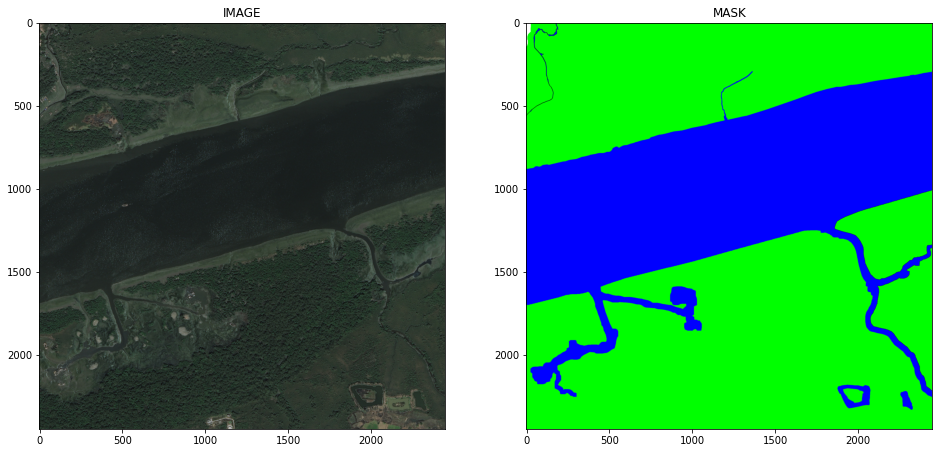

In [168]:
index = 0

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [169]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

# **Resnet 50**

In [170]:
import albumentations as aug
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [171]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None, preprocessing=None):
        self.df = df
        self.augmentations = augmentations
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = image[:,:,::-1]
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        # mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,::-1]
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = data['image'], data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [172]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment, get_preprocessing(preprocessing_fn))
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment, get_preprocessing(preprocessing_fn))
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment, get_preprocessing(preprocessing_fn))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [173]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [174]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([7, 3, 320, 320]), torch.Size([7, 1, 320, 320]))

In [175]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.model = UnetPlusPlus(
#             encoder_name="timm-regnety_120",
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=len(CLASSES),
#             activation="softmax"
#         )
        self.model = DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [176]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [7, 7, 320, 320]          --
├─DeepLabV3Plus: 1-1                                         [7, 7, 320, 320]          --
│    └─ResNetEncoder: 2-1                                    [7, 3, 320, 320]          --
│    │    └─Conv2d: 3-1                                      [7, 64, 160, 160]         9,408
│    │    └─BatchNorm2d: 3-2                                 [7, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                        [7, 64, 160, 160]         --
│    │    └─MaxPool2d: 3-4                                   [7, 64, 80, 80]           --
│    │    └─Sequential: 3-5                                  [7, 256, 80, 80]          215,808
│    │    └─Sequential: 3-6                                  [7, 512, 40, 40]          1,219,584
│    │    └─Sequential: 3-7                                  [7, 1024, 20, 20] 

In [178]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-resnet50")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [179]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [180]:
trainer.test(model, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9491825103759766     │
│       test/F1score        │    0.8221387267112732     │
│         test/IoU          │    0.7262035608291626     │
│         test/Loss         │    0.4123762547969818     │
│      test/Precision       │    0.8221387267112732     │
│        test/Recall        │    0.8221387267112732     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.4123762547969818,
  'test/IoU': 0.7262035608291626,
  'test/Accuracy': 0.9491825103759766,
  'test/Precision': 0.8221387267112732,
  'test/Recall': 0.8221387267112732,
  'test/F1score': 0.8221387267112732}]

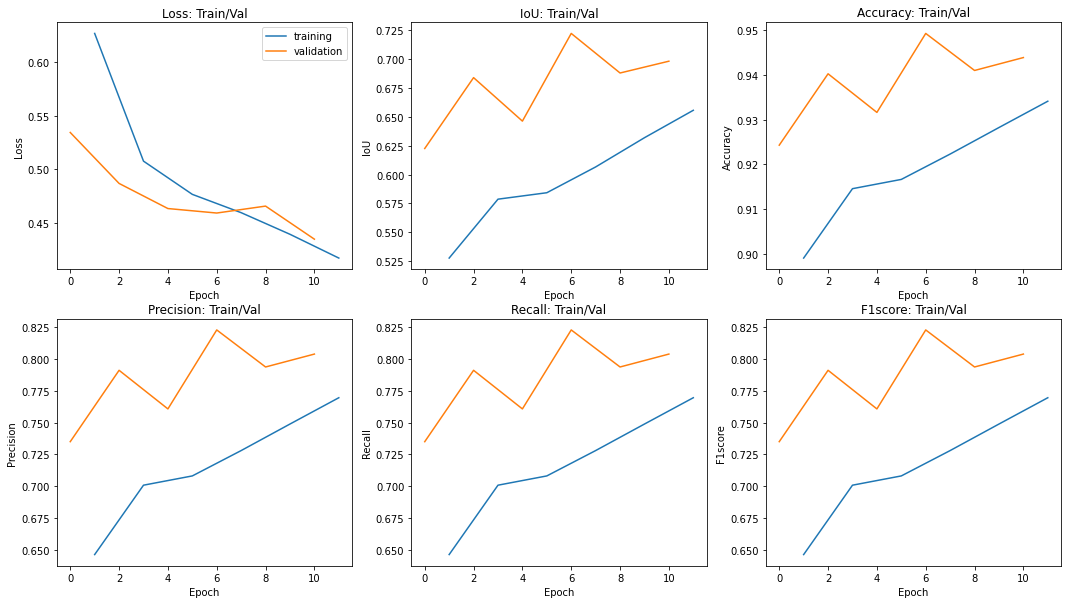

In [181]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-resnet50/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

# Inference

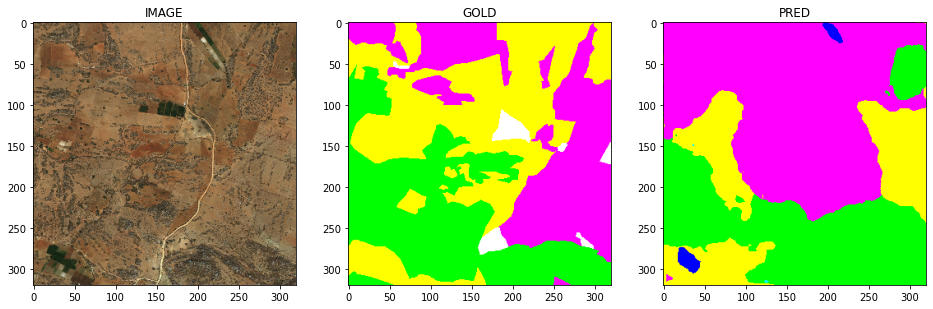

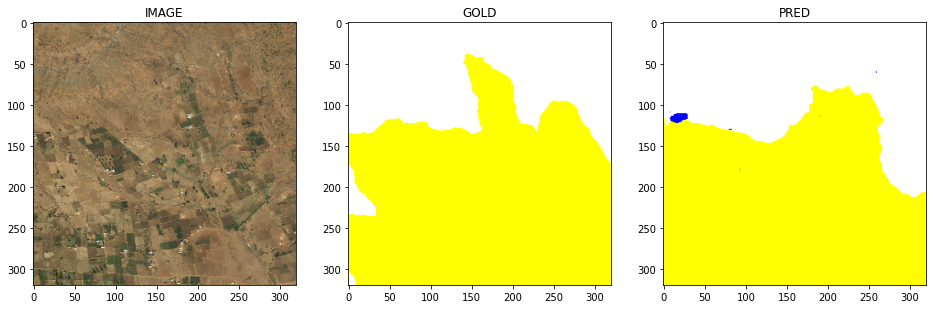

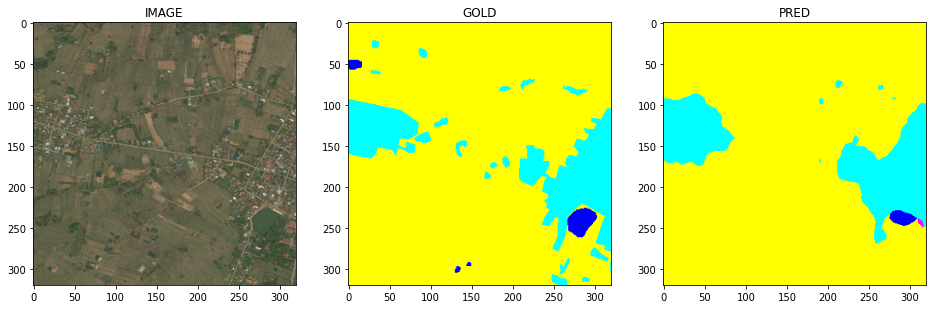

In [183]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)

# Encoder - resnet18

In [184]:
import albumentations as aug
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [185]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.io import read_image

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None, preprocessing=None):
        self.df = df
        self.augmentations = augmentations
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = image[:,:,::-1]
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask = cv2.imread(row.MASKS)
#         mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,::-1]
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = data['image'], data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()
        
        return image, mask

In [186]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment, get_preprocessing(preprocessing_fn))
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment, get_preprocessing(preprocessing_fn))
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment, get_preprocessing(preprocessing_fn))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [188]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [189]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([7, 3, 320, 320]), torch.Size([7, 1, 320, 320]))

In [190]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score
pred_dump = []
class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.model = UnetPlusPlus(
#             encoder_name="timm-regnety_120",
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=len(CLASSES),
#             activation="softmax"
#         )
        self.model = DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        
        if targets is not None:
#             pred_dump.append({
#                 'pred': outputs.argmax(dim=1).unsqueeze(1).type(torch.int64),
#                 'gold': targets
#             })
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [191]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [7, 7, 320, 320]          --
├─DeepLabV3Plus: 1-1                                         [7, 7, 320, 320]          --
│    └─ResNetEncoder: 2-1                                    [7, 3, 320, 320]          --
│    │    └─Conv2d: 3-1                                      [7, 64, 160, 160]         9,408
│    │    └─BatchNorm2d: 3-2                                 [7, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                        [7, 64, 160, 160]         --
│    │    └─MaxPool2d: 3-4                                   [7, 64, 80, 80]           --
│    │    └─Sequential: 3-5                                  [7, 64, 80, 80]           147,968
│    │    └─Sequential: 3-6                                  [7, 128, 40, 40]          525,568
│    │    └─Sequential: 3-7                                  [7, 256, 20, 20]    

In [192]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
EPOCHS = 15
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-encoder-resnet18")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [193]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [194]:
trainer.test(model, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9422793984413147     │
│       test/F1score        │    0.7979775667190552     │
│         test/IoU          │    0.6994313597679138     │
│         test/Loss         │    0.4196537733078003     │
│      test/Precision       │    0.7979775667190552     │
│        test/Recall        │    0.7979775667190552     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.4196537733078003,
  'test/IoU': 0.6994313597679138,
  'test/Accuracy': 0.9422793984413147,
  'test/Precision': 0.7979775667190552,
  'test/Recall': 0.7979775667190552,
  'test/F1score': 0.7979775667190552}]

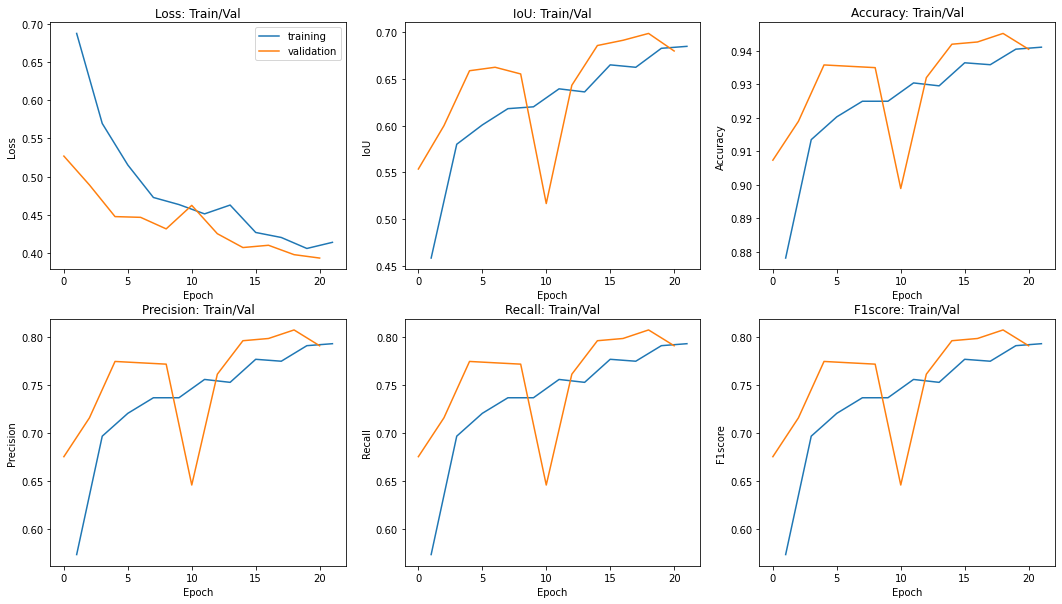

In [197]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-encoder-resnet18/version_3/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

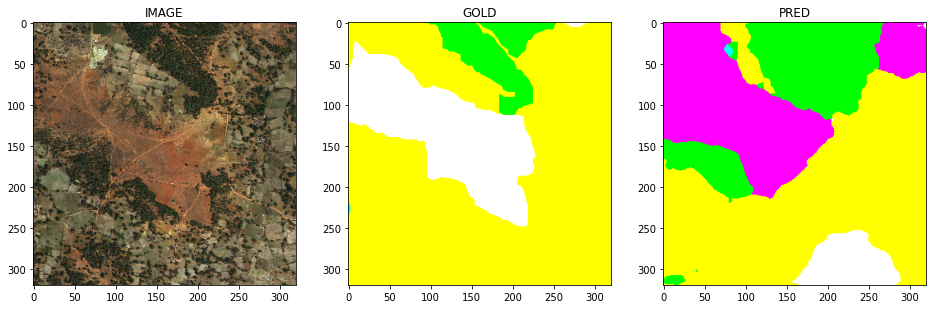

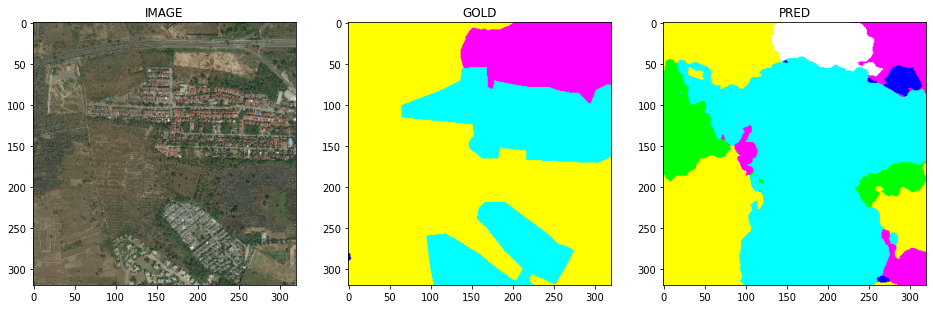

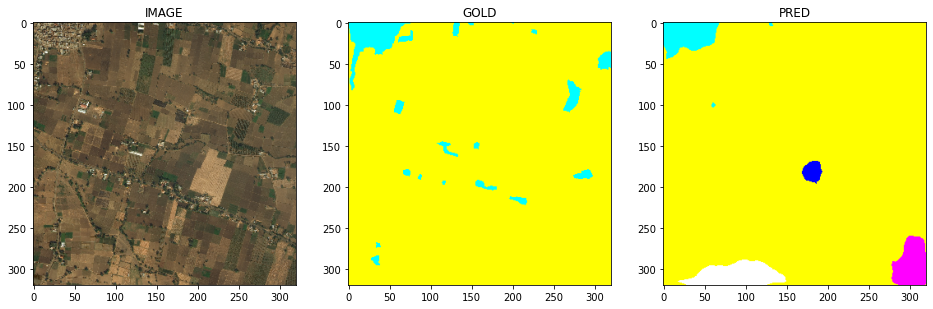

In [198]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test[-10:], batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)

# **Resnet 101**

In [199]:
import albumentations as aug
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'imagenet'

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [200]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None, preprocessing=None):
        self.df = df
        self.augmentations = augmentations
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = image[:,:,::-1]
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        # mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,::-1]
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = data['image'], data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask

In [201]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment, get_preprocessing(preprocessing_fn))
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment, get_preprocessing(preprocessing_fn))
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment, get_preprocessing(preprocessing_fn))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [202]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [203]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

(torch.Size([7, 3, 320, 320]), torch.Size([7, 1, 320, 320]))

In [204]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.model = UnetPlusPlus(
#             encoder_name="timm-regnety_120",
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=len(CLASSES),
#             activation="softmax"
#         )
        self.model = DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

In [205]:
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [7, 7, 320, 320]          --
├─DeepLabV3Plus: 1-1                                         [7, 7, 320, 320]          --
│    └─ResNetEncoder: 2-1                                    [7, 3, 320, 320]          --
│    │    └─Conv2d: 3-1                                      [7, 64, 160, 160]         9,408
│    │    └─BatchNorm2d: 3-2                                 [7, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                        [7, 64, 160, 160]         --
│    │    └─MaxPool2d: 3-4                                   [7, 64, 80, 80]           --
│    │    └─Sequential: 3-5                                  [7, 256, 80, 80]          420,864
│    │    └─Sequential: 3-6                                  [7, 512, 40, 40]          2,405,376
│    │    └─Sequential: 3-7                                  [7, 1024, 20, 20] 

In [206]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log-encoder-resnet101_32x8d")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

In [207]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [208]:
trainer.test(model, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9481917023658752     │
│       test/F1score        │    0.8186715245246887     │
│         test/IoU          │     0.721318781375885     │
│         test/Loss         │    0.39198556542396545    │
│      test/Precision       │    0.8186715245246887     │
│        test/Recall        │    0.8186715245246887     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.39198556542396545,
  'test/IoU': 0.721318781375885,
  'test/Accuracy': 0.9481917023658752,
  'test/Precision': 0.8186715245246887,
  'test/Recall': 0.8186715245246887,
  'test/F1score': 0.8186715245246887}]

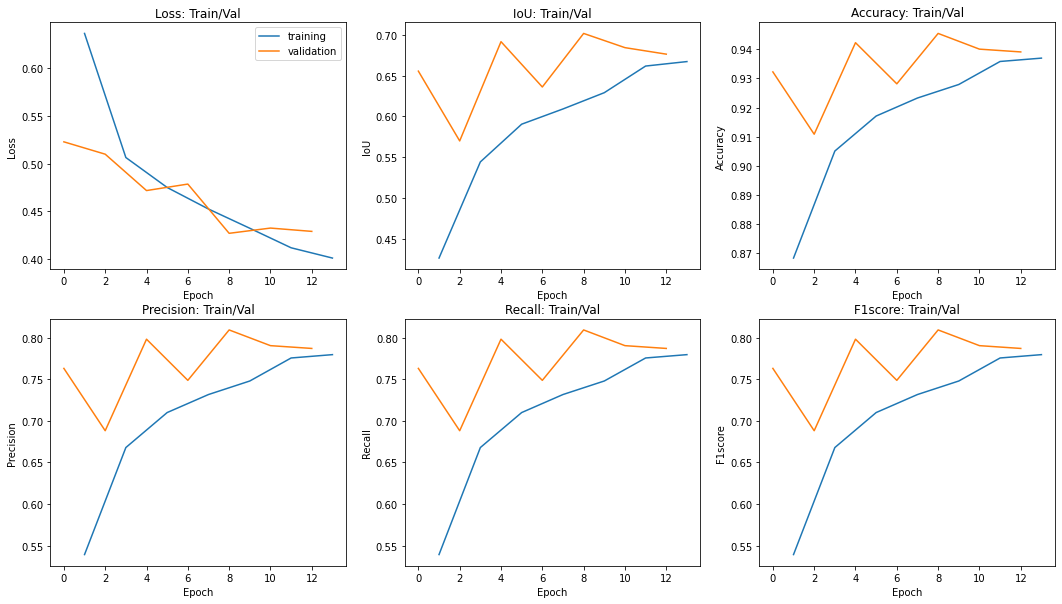

In [210]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log-encoder-resnet101_32x8d/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

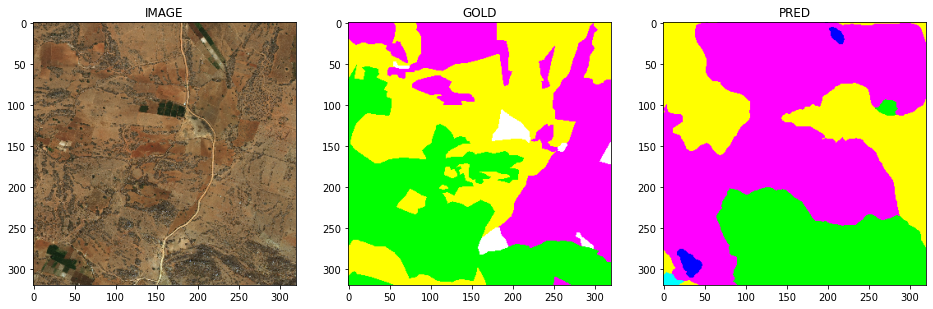

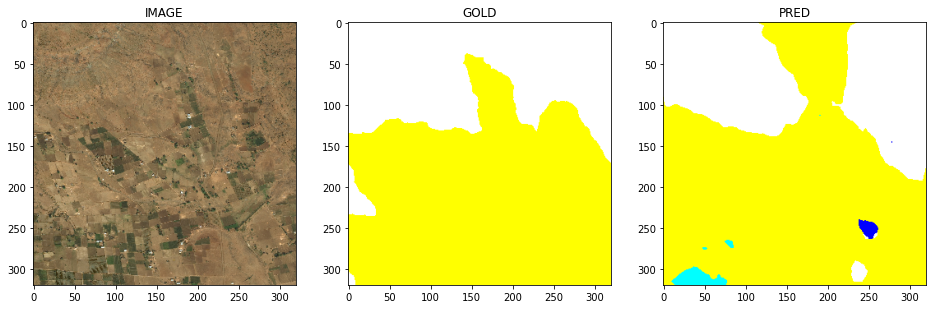

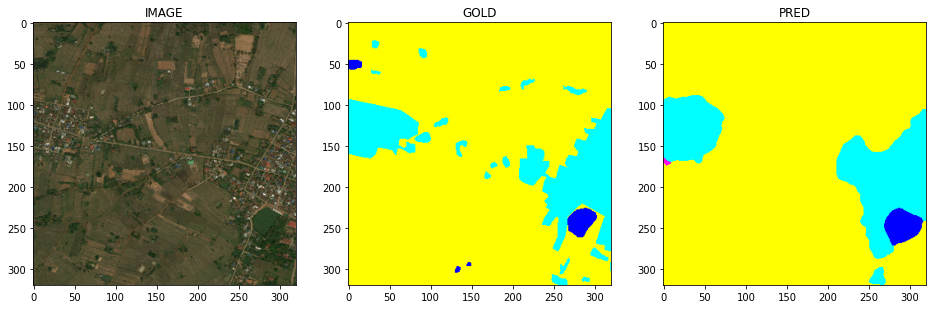

In [211]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()
image, mask = next(iter(data_module.test_dataloader()))
outputs = model(image)
for i in range(BATCH_SIZE//2):
    pred_category = outputs[i].argmax(dim=0).unsqueeze(1).type(torch.int64).squeeze()
    pred_rgb = category2rgb(pred_category.cpu())
    gold_mask = category2rgb(mask[i].squeeze().cpu())
    test_img = image[i].permute(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))
    ax1.set_title('IMAGE')
    ax1.imshow(test_img)

    ax2.set_title('GOLD')
    ax2.imshow(gold_mask)

    ax3.set_title('PRED')
    ax3.imshow(pred_rgb)